In [17]:
!pip install kaggle -q

import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
!chmod 600 /content/kaggle.json

!kaggle datasets download -d onurkarasoy/turkish-sms-collection

import zipfile
with zipfile.ZipFile("turkish-sms-collection.zip","r") as zip_ref:
    zip_ref.extractall("turkish_sms")




Dataset URL: https://www.kaggle.com/datasets/onurkarasoy/turkish-sms-collection
License(s): unknown
turkish-sms-collection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [18]:
import pandas as pd


df = pd.read_csv(
    "/content/turkish_sms/TurkishSMSCollection.csv",
    sep=";",
    encoding="utf-8"
)

print(df.head(30))
print(df.info())


                                              Message  Group GroupText
0                                            125 lira      2    Normal
1               Baskanin aksam toplantısi fenaymis :)      2    Normal
2                 Bilal yalçnlara ne zaman gidiyoruz?      2    Normal
3   BiP ile mesajlarimi aninda, daha eglenceli gon...      1      Spam
4   DIGITURKTEN FIRSAT! SiZE OZEL YIL SONUNA KADAR...      1      Spam
5   İyi ya dokuz eylül iyidir arş.gör falan kovala ;)      2    Normal
6   İyiyim teşekkürler oturuyoruz nazarda arkadaşl...      2    Normal
7             Kapatamıyorun ayarlara girmem lazım :)       2    Normal
8                  Menüye girsem görünür mü acaba ??       2    Normal
9                 Önemli değil hocam iyi akşamlar ;)       2    Normal
10     Senin nasil arastirma görevlisi olacak gibi mi      2    Normal
11                                          Tamam :)       2    Normal
12  Tamam abi iyi yolculuklar. Ben hastanede yim b...      2    Normal
13    

In [19]:
!pip install stanza -q
import stanza
import re
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
turkish_stopwords = set(stopwords.words("turkish"))
stanza.download('tr')

nlp = stanza.Pipeline('tr', processors='tokenize,mwt,pos,lemma')
def preprocess_text_stanza(text):
    text = text.replace("İ", "i").replace("I", "ı")
    text = re.sub(r"http\S+|www\.\S+", " URLTOKEN ", text)
    text = re.sub(r"\d+", " NUMTOKEN ", text)
    text = text.lower()
    text = re.sub(r"[^a-zçğıöşü\s]", " ", text)
    text = re.sub(r'\s+', ' ', text).strip()


    doc = nlp(text)
    cleaned_tokens = []

    for sent in doc.sentences:
        for word in sent.words:
            tok = (word.text or "").lower().strip()
            if not tok:
                continue
            if tok == "numtoken":
                cleaned_tokens.append("<NUM>")
                continue
            if tok == "urltoken":
                cleaned_tokens.append("<URL>")
                continue
            if tok in turkish_stopwords:
                continue

            lemma = (word.lemma or tok).lower().strip()

            if len(lemma) == 1:
                continue

            if lemma and lemma not in turkish_stopwords:
                cleaned_tokens.append(lemma)


    return " ".join(cleaned_tokens)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Downloading default packages for language: tr (Turkish) ...
INFO:stanza:File exists: /root/stanza_resources/tr/default.zip
INFO:stanza:Finished downloading models and saved to /root/stanza_resources
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Downloaded file to /root/stanza_resources/resources.json
INFO:stanza:Loading these models for language: tr (Turkish):
| Processor | Package       |
-----------------------------
| tokenize  | imst          |
| mwt       | imst          |
| pos       | imst_charlm   |
| lemma     | imst_nocharlm |

INFO:stanza:Using device: cpu
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Done loading processors!


In [20]:
df = df[["Message", "GroupText"]].copy()
df = df.rename(columns={"Message": "text", "GroupText": "label_text"})

df["label"] = df["label_text"].map({"Normal": 0, "Spam": 1})

df = df.dropna(subset=["text", "label_text", "label"])


In [21]:
!pip install tqdm -q
from tqdm.notebook import tqdm
tqdm.pandas()

df["clean_text"] = df["text"].progress_apply(preprocess_text_stanza)

df[["text", "clean_text", "label_text"]].head(10)

  0%|          | 0/4751 [00:00<?, ?it/s]

,text,clean_text,label_text
0,125 lira,<NUM> lira,Normal
1,Baskanin aksam toplantısi fenaymis :),baskan aksam toplantı fenaymis,Normal
2,Bilal yalçnlara ne zaman gidiyoruz?,bilal yalçn zaman git,Normal
3,"BiP ile mesajlarimi aninda, daha eglenceli gon...",bip mesaj an eglence li gonder sen hemen kulla...,Spam
4,DIGITURKTEN FIRSAT! SiZE OZEL YIL SONUNA KADAR...,dıgıturk fırsat ozel yıl son kadar <NUM> uzeri...,Spam
5,İyi ya dokuz eylül iyidir arş.gör falan kovala ;),iyi dokuz eylül iyi arş gör falan kov,Normal
6,İyiyim teşekkürler oturuyoruz nazarda arkadaşl...,iyi teşekkür otur nazar arkadaş sen nas geçen ...,Normal
7,Kapatamıyorun ayarlara girmem lazım :),kapa ayar gir lazı,Normal
8,Menüye girsem görünür mü acaba ??,menüye gir görün,Normal
9,Önemli değil hocam iyi akşamlar ;),önem li değil hoca iyi akşam,Normal


In [22]:
df.to_csv("temiz_veri.csv", index=False)

Veri setindeki sınıf sayıları:
label_text
Spam      2536
Normal    2215
Name: count, dtype: int64


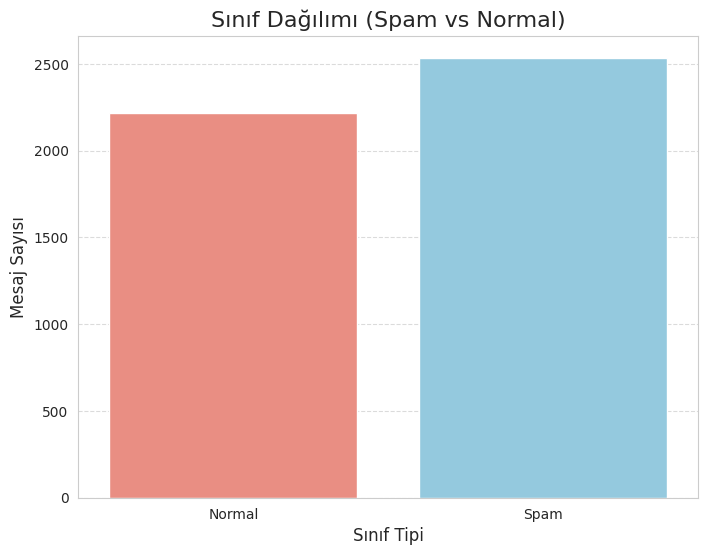

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Sınıf sayıları
print("Veri setindeki sınıf sayıları:")
print(df["label_text"].value_counts())

# 2. Grafik
plt.figure(figsize=(8, 6))

sns.countplot(
    x="label_text",
    data=df,
    hue="label_text",          # <- yeni sürümde gerekli
    palette=["salmon", "skyblue"],
    legend=False               # <- eski davranışı korur
)

# 3. Başlık ve etiketler
plt.title("Sınıf Dağılımı (Spam vs Normal)", fontsize=16)
plt.xlabel("Sınıf Tipi", fontsize=12)
plt.ylabel("Mesaj Sayısı", fontsize=12)

# 4. Izgara
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()


In [24]:
!pip install scikit-learn -q
from sklearn.feature_extraction.text import  TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split


df["kelime_sayisi"] = df["clean_text"].apply(lambda x: len(str(x).split()))
df["mesaj_uzunlugu"] = df["clean_text"].apply(lambda x: len(str(x)))
df["url_var_mi"] = df["text"].apply(lambda x: 1 if "http" in str(x).lower() or "www" in str(x).lower() else 0)
df["num_var_mi"] = df["clean_text"].apply(lambda x: 1 if "<NUM>" in str(x) else 0)

y = df["label"]
X_text = df["clean_text"]
X_num = df[["kelime_sayisi", "mesaj_uzunlugu", "url_var_mi", "num_var_mi"]].values

X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_text, X_num, y, test_size=0.2, random_state=42, stratify=y
)

tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
X_train_tfidf = tfidf.fit_transform(X_train_text.astype(str))
X_test_tfidf = tfidf.transform(X_test_text.astype(str))

X_train = hstack([X_train_tfidf, csr_matrix(X_train_num)])
X_test = hstack([X_test_tfidf, csr_matrix(X_test_num)])
#csr_matrix büyük  seyrek sparse matrisleri sadece dolu hücreleri kaydederek saklıyormuş



In [25]:

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    ),
    "Linear SVM": LinearSVC()
}

results = []

# Her model için eğitim + tahmin + metrik
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, pos_label=1)
    rec = recall_score(y_test, y_pred, pos_label=1)
    f1 = f1_score(y_test, y_pred, pos_label=1)

    results.append({
        "Model": name,
        "Accuracy": round(acc, 4),
        "Precision": round(prec, 4),
        "Recall": round(rec, 4),
        "F1-score": round(f1, 4)
    })
    print(name)
    print("-" * 30)
    print(classification_report(y_test, y_pred, target_names=["Normal", "Spam"]))
    print("*" * 30)




Logistic Regression
------------------------------
              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99       443
        Spam       0.99      1.00      0.99       508

    accuracy                           0.99       951
   macro avg       0.99      0.99      0.99       951
weighted avg       0.99      0.99      0.99       951

******************************
Naive Bayes
------------------------------
              precision    recall  f1-score   support

      Normal       1.00      0.87      0.93       443
        Spam       0.90      1.00      0.95       508

    accuracy                           0.94       951
   macro avg       0.95      0.93      0.94       951
weighted avg       0.94      0.94      0.94       951

******************************
Random Forest
------------------------------
              precision    recall  f1-score   support

      Normal       0.99      1.00      1.00       443
        Spam       1.00      0.99   

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [26]:
results_df = pd.DataFrame(results)
print(results_df)

                 Model  Accuracy  Precision  Recall  F1-score
0  Logistic Regression    0.9905     0.9864  0.9961    0.9912
1          Naive Bayes    0.9380     0.8959  1.0000    0.9451
2        Random Forest    0.9958     0.9980  0.9941    0.9961
3           Linear SVM    0.9842     0.9713  1.0000    0.9855


In [27]:

best_model_name = results_df.sort_values("F1-score", ascending=False).iloc[0]["Model"]
print(f"\nEn iyi model: {best_model_name}")


En iyi model: Random Forest


<Figure size 450x450 with 0 Axes>

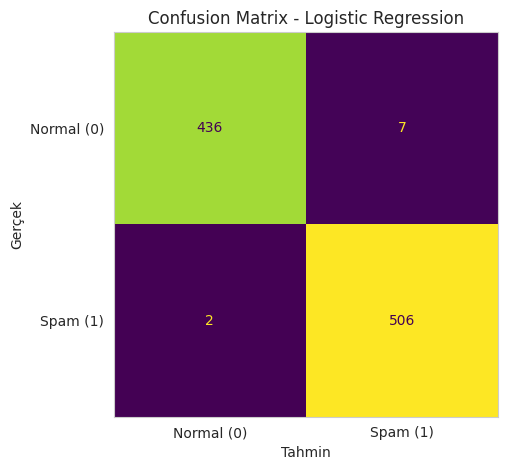

<Figure size 450x450 with 0 Axes>

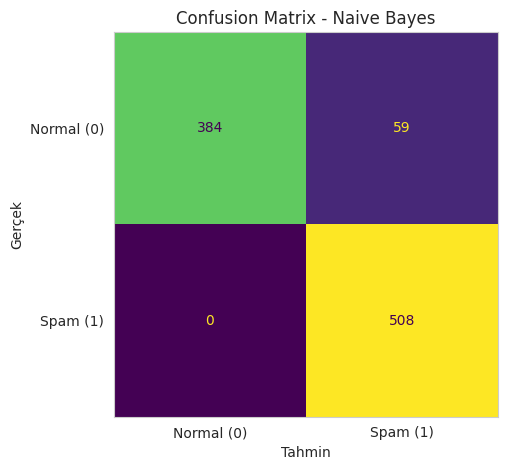

<Figure size 450x450 with 0 Axes>

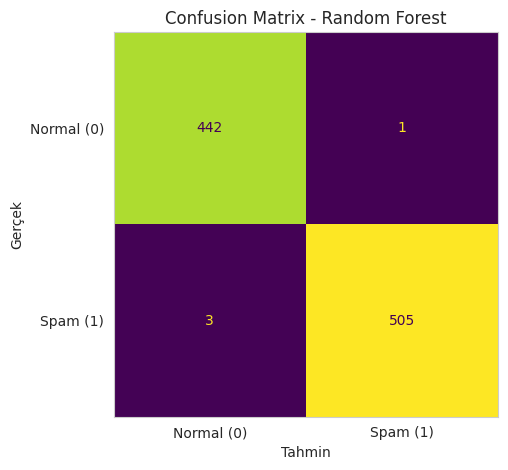

<Figure size 450x450 with 0 Axes>

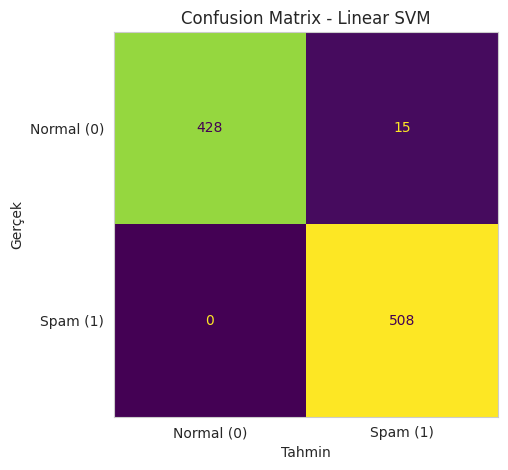

In [28]:

for name, model in models.items():
    y_pred = model.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm,
        display_labels=["Normal (0)", "Spam (1)"]
    )

    plt.figure(figsize=(4.5, 4.5))
    disp.plot(values_format="d", colorbar=False)
    plt.grid(False)
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Tahmin")
    plt.ylabel("Gerçek")
    plt.tight_layout()
    plt.show()


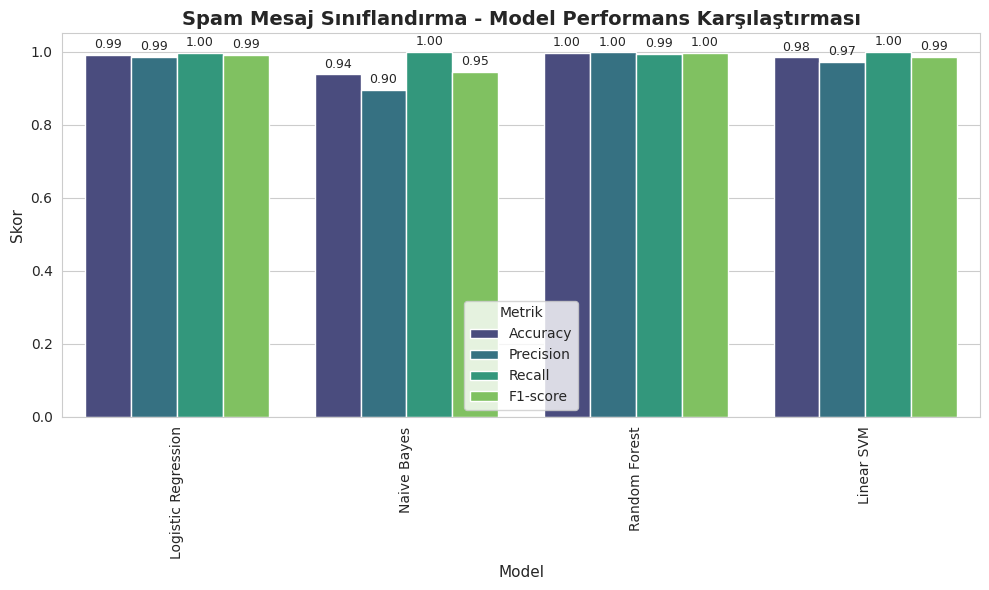

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.figure(figsize=(10,6))

df_melt = results_df.melt(id_vars="Model", var_name="Metrik", value_name="Değer")

ax = sns.barplot(x="Model", y="Değer", hue="Metrik", data=df_melt, palette="viridis")

plt.title("Spam Mesaj Sınıflandırma - Model Performans Karşılaştırması", fontsize=14, fontweight="bold")
plt.xlabel("Model", fontsize=11)
plt.ylabel("Skor", fontsize=11)
plt.xticks(rotation=90)

for p in ax.patches:
    val = p.get_height()
    if val > 0:
        ax.text(
            p.get_x() + p.get_width()/2,
            val + 0.01,
            f"{val:.2f}",
            ha="center",
            va="bottom",
            fontsize=9
        )

plt.tight_layout()
plt.show()


